# Modelo para obtener las probabilidades de que una Mujer sea victima de violencia en los diferentes distritos de Lima Metropolitana

El modelo tiene como fin prevenir que una mujer sea victima de violencia. Para ello se va a crear un modelo que retorne las probabilidades de que una mujer sea victima de violencia en los diferentes distritos de Lima Metropolitana dado unos datos de entrada brindados por la persona.

### Importamos las siguientes librerias

In [887]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

## 1. Preparacion del Dataset

El dataset escogido contiene los registros de casos recogidos por el Centro de Emergencia de la Mujer (CEM) del Año 2020. Fue obtenido del Portal estadistico del Programa Nacional Aurora https://portalestadistico.aurora.gob.pe/bases-de-datos-2020/

In [888]:
pd.set_option('display.max_columns', None)

In [889]:
dataframe = pd.read_csv("casos_cem_2020.csv")

El dataset cuenta con 114495 registros y 159 variables

In [890]:
dataframe.head(5)

,Unnamed: 0,CEM,CONDICION,FECHA_INGRESO,INFORMANTE,FORMA_INGRESO,VICTIMA_PERUANA,VICTIMA_CUENTA_DNI,VICTIMA_EXTRANJERA,VICTIMA_PAIS_EXTRANJERO,VICTIMA_CARNE_EXTRANJERIA,VICTIMA_SOLICITANTE_REFUGIO,VICTIMA_REFUGIADO,VICTIMA_SOLICITANTE_ASILO,VICTIMA_ASILADO,VICTIMA_APATRIDA,VICTIMA_OTRA_SIT_MIGR,VICTIMA_NINGUNA_SIT_MIGR,EDAD_VICTIMA,SEXO_VICTIMA,VICTIMA_GESTANDO,HIJAS_VIVAS,HIJOS_VIVOS,LENGUA_MATERNA_VICTIMA,ETNIA_VICTIMA,DPTO_DOMICILIO,PROV_DOMICILIO,DIST_DOMICILIO,CENTRO_POBLADO_DOMICILIO,AREA_RESIDENCIA_DOMICILIO,ESTADO_CIVIL_VICTIMA,NIVEL_EDUCATIVO_VICTIMA,ESTUDIA,LUGAR_ESTUDIA,TIPO_GESTION_ESTUDIA,TRABAJA_VICTIMA,OCUPACION_VICTIMA,SIS_SEGURO,ESSALUD_SEGURO,OTRO_SEGURO,NINGUN_SEGURO,AGRESOR_PERUANO,AGRESOR_CUENTA_DNI,AGRESOR_EXTRANJERO,AGRESOR_PAIS_EXTRANJERO,AGRESOR_CARNE_EXTRANJERIA,AGRESOR_SOLICITANTE_REFUGIO,AGRESOR_REFUGIADO,AGRESOR_SOLICITANTE_ASILO,AGRESOR_ASILADO,AGRESOR_APATRIDA,AGRESOR_OTRA_SIT_MIGR,AGRESOR_NINGUNA_SIT_MIGR,VINCULO_AGRESOR_VICTIMA,VINCULO_PAREJA,VINCULO_FAMILIAR,SIN_VINCULO,AGRESOR_VIVE_CASA_VICTIMA,EDAD_AGRESOR,SEXO_AGRESOR,NIVEL_EDUCATIVO_AGRESOR,TRABAJA_AGRESOR,OCUPACION_AGRESOR,PERTURBACION_POSESION,MENOSCABO_TENENCIA_BIENES,PERDIDA_DERECHOS_PATRIMONIALES,LIMITACION_RECURSOS_ECONOMICOS,PRIVACION_MEDIOS_INDISPENSABLES,INCUMPLIMIENTO_OBLIGACION_ALIMENTARIA,CONTROL_DE_INGRESOS,PERCEPCION_SALARIO_MENOR,OTRA_VECON_PATRIM,GRITOS_INSULTOS,VIOLENCIA_RACIAL,INDIFERENCIA,DISCR_ORIENTACION_SEXUAL,DISCR_GENERO,DISCR_IDENTIDAD_GENERO,RECHAZO,DESVALORIZACION_HUMILLACION,AMENAZA_QUITAR_HIJOS,OTRAS_AMENAZAS,PROHIBE_RECIBIR_VISITAS,PROHIBE_ESTUDIAR_TRABAJAR_SALIR,ROMPE_DESTRUYE_COSAS,VIGILANCIA_CONTINUA_PERSECUCION,BOTAR_CASA,AMENAZA_DE_MUERTE,ABANDONO,OTRA_VPSI,PUNTAPIES_PATADAS,PU�ETAZOS,BOFETADAS,JALONES_CABELLO,OTRAS_AGRESIONES,EMPUJONES,GOLPES_CON_PALOS,LATIGAZO,AHORCAMIENTO,HERIDAS_CON_ARMAS,GOLPES_CON_OBJETOS_CONTUNDENTES,NEGLIGENCIA,OTRA_VFIS,HOSTIGAMIENTO_SEXUAL,ACOSO_SEX_ESP_PUB,VIOLACION,ACTOS_CONTRA_EL_PUDOR,TRATA_CON_FINES_EXPLOTACION_SEXUAL,EXPLOTACION_SEXUAL,PORNOGRAFIA,OTRA_VSEX,DEPENDE_VICTIMA_FEMINICIDIO,PRIMERA_VEZ_AGREDE,N_A�OS,N_MESES,N_SEMANAS,FRECUENCIA_AGREDE,ESTADO_AGRESOR_U_A,ESTADO_AGRESOR_G,ESTADO_VICTIMA_U_A,ESTADO_VICTIMA_G,TRATAMIENTO_PSICOLOGICO,TRATAMIENTO_PSIQUIATRICO,ATENCION_MEDICA,OTRO_TRATAMIENTO,NINGUN_TRATAMIENTO,CONTINUA_RECIBIENDO_TRATAMIENTO,VINCULO_AFECTIVO_FAMILIA,VINCULO_AFECTIVO_AMIGOS,VINCULO_AFECTIVO_VECINOS,VINCULO_AFECTIVO_ASOCIACIONES,VINCULO_AFECTIVO_ORGANIZACIONES_CIVICAS,VINCULO_AFECTIVO_COMPA�EROS_TRABAJO,VINCULO_AFECTIVO_OTRO,VINCULO_AFECTIVO_NINGUNO,REDES_FAM_SOC,APOYO_EMOCIONAL,APOYO_COGNITIVO,APOYO_INSTRUMENTAL,APOYO_MATERIAL,FACTOR_AGRESOR_CONSUMO_ALCOHOL,FACTOR_AGRESOR_CONSUME_DROGA,FACTOR_VICTIMA_DISCAPACIDAD,FACTOR_VICTIMA_ABUSO_CONSUMO_ALCOHOL,FACTOR_VICTIMA_CONSUME_DROGAS,VULNERABILIDAD_VICTIMA_LGTBI,VULNERABILIDAD_VICTIMA_VIH,VIOLENCIA_CARCELARIA,NIVEL_DE_RIESGO_VICTIMA,INTERPUSO_DENUNCIA,DONDE_INTERPUSO_DENUNCIA,DESEA_DENUNCIAR,CUENTA_MEDIDAS_PROTECCION,CUENTA_MEDIDAS_CAUTELARES,DESEA_PATROCINIO_LEGAL,CASO_TENTATIVA_DE_FEMINICIDIO,LUGAR_TENTATIVA_DE_FEMINICIDIO,SITUACION_AGRESOR,TIPO_VIOLENCIA
0,1,ABANCAY,3,2020-01-08,1,10,1,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,0,0.0,1,0,10,1,3,1,1,1,U,1,7,1,3.0,2.0,0,NaN,1.0,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,3.0,NaN,NaN,1,35.0,1,6.0,1.0,36.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1.0,0.0,0.0,5.0,2,1.0,1,1.0,NaN,NaN,NaN,NaN,1.0,0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,1,1.0,NaN,0.0,0.0,1,0.0,NaN,NaN,2
1,2,ABANCAY,1,2020-01-10,1,1,1,1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45,0,0.0,0,1,10,7,3,1,1,1,U,2,10,1,3.0,2.0,1,89.0,NaN,1.0,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,NaN,NaN,2,35.0,1,10.0,1.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [891]:
dataframe.shape

(114495, 159)

In [892]:
from pandasql import sqldf

In [893]:
pysqldf = lambda q: sqldf(q, globals())

Exploramos el dataset y se puede observar que en lugar de sus nombres los departamentos estan codificados con números.

In [894]:
#NÚMERO DE CASOS DE LOS 5 DEPARTAMENTOS CON MÁS CASOS
pysqldf("SELECT COUNT(*) AS casos, DPTO_DOMICILIO FROM dataframe GROUP BY DPTO_DOMICILIO ORDER BY casos DESC;").head(5)

Haciendo uso de los Códigos de Ubicación Geográfica (UBIGEO) brindados por la INEI se pudo saber que el código del departamento de Lima es 15. Asimismo, se pudo saber que el código para Lima Metropolitana es 1

In [895]:
#NUMERO DE CASOS DE LAS PROVINCIAS DEL DEPARTAMENTO DE LIMA
pysqldf("SELECT COUNT(*) AS casos_lima_prov, PROV_DOMICILIO FROM dataframe WHERE DPTO_DOMICILIO = 15 GROUP BY PROV_DOMICILIO ORDER BY casos_lima_prov DESC;")

A continuación realizamos una exploracion del numero de casos de violencia contra la Mujer en los diferentes distritos de Lima Metropolitana.

In [896]:
#NUMERO DE CASOS DE LOS DISTRITOS DE LIMA_METROPOLITANA
pysqldf("SELECT COUNT(*) AS casos_lima_metro, DIST_DOMICILIO FROM dataframe WHERE DPTO_DOMICILIO = 15 AND PROV_DOMICILIO = 1 GROUP BY DIST_DOMICILIO ORDER BY casos_lima_metro DESC;")

De las 159 variables procedemos a retirar las variables que no contribuyan a la creacion del modelo predictivo para obtener la probabilidad de que una Mujer sufra de violencia en un distrito. Por ejemplo, como nuestra meta es prevenir que suceda un caso de violencia para una mujer quitamos las variables relacionadas con el agresor, ya que estos datos tambien son registrados por el CEM.

In [897]:
#VARIABLES DEL AGRESOR
dataframe.columns.get_loc("AGRESOR_PERUANO")

41

In [898]:
dataframe.columns.get_loc("SITUACION_AGRESOR")

157

In [899]:
#Eliminar variables del agresor
droprange = list(range(41, 158))
dataframe.drop(dataframe.columns[droprange], axis=1, inplace=True)

In [900]:
#dataframe.head(5)

De igual manera quitamos algunas variables que se pueden considerar irrelevantes como si la victima cuenta o no con dni y su estado migratorio.

In [901]:
#VARIABLES NO RELEVANTES
dataframe.columns.get_loc("VICTIMA_CUENTA_DNI")

7

In [902]:
dataframe.columns.get_loc("VICTIMA_NINGUNA_SIT_MIGR")

17

In [903]:
#ELIMINAR VARIABLES NO RELEVANTES
droprange = list(range(7, 18))
dataframe.drop(dataframe.columns[droprange], axis=1, inplace=True)

In [904]:
#dataframe.head(5)

In [905]:
dataframe.drop(['CONDICION','Unnamed: 0', 'CEM', 'FECHA_INGRESO', 'INFORMANTE', 'FORMA_INGRESO', 'LENGUA_MATERNA_VICTIMA', 'ETNIA_VICTIMA', 'CENTRO_POBLADO_DOMICILIO', 'AREA_RESIDENCIA_DOMICILIO', 'NIVEL_EDUCATIVO_VICTIMA', 'LUGAR_ESTUDIA', 'TIPO_GESTION_ESTUDIA', 'OCUPACION_VICTIMA'], axis=1, inplace=True)

Rellenamos con 0s los valores nan.

In [906]:
#Rellenamos con 0s los valors nan
dataframe = dataframe.fillna(0)

Creamos la variable "TIENE_SEGURO", el cual es la suma de las variables de los diferentes seguros de salud. Tambien se crea la variable "TIENE_HIJOS" el cual es la suma de las variables "HIJAS_VIVAS" e "HIJOS_VIVOS".

In [907]:
dataframe['SIS_SEGURO'] = dataframe['SIS_SEGURO'].astype('int64')
dataframe['ESSALUD_SEGURO'] = dataframe['ESSALUD_SEGURO'].astype('int64')
dataframe['OTRO_SEGURO'] = dataframe['OTRO_SEGURO'].astype('int64')
dataframe['VICTIMA_GESTANDO'] = dataframe['VICTIMA_GESTANDO'].astype('int64')

In [908]:
#dataframe.dtypes

In [909]:
#AGREGAR VARIABLE TIENE SEGURO = SUMA DE LOS SEGUROS
TIENE_SEGURO = dataframe['SIS_SEGURO'] + dataframe['ESSALUD_SEGURO'] + dataframe['OTRO_SEGURO']
dataframe.insert(loc=len(dataframe.columns)-1, column='TIENE_SEGURO', value=TIENE_SEGURO)

In [910]:
dataframe.drop(['SIS_SEGURO', 'ESSALUD_SEGURO', 'OTRO_SEGURO', 'NINGUN_SEGURO'], axis=1, inplace=True)

In [911]:
#AGREGAR VARIABLE TIENE HIJOS (1) = SUMA DE HIJOS E HIJAS 
N_HIJOS = dataframe['HIJAS_VIVAS'] + dataframe['HIJOS_VIVOS']
dataframe.insert(loc=6, column='N_HIJOS', value=N_HIJOS)

In [912]:
dataframe.drop(['HIJAS_VIVAS', 'HIJOS_VIVOS', 'TIENE_SEGURO','ESTADO_CIVIL_VICTIMA'], axis=1, inplace=True)

In [913]:
#dataframe.dtypes

In [914]:
#AHORA REDUCIMOS EL DATASET

In [915]:
#dataframe.size

Utilizando la variable "SEXO_VICTIMA" realizamos una inspeccion para saber si todos los resgistros tienen como victima a la mujer. Sin embargo, observamos que tambien hay casos registrados por el CEM en que la victima es hombre. Por ello, se procede a elimnar los registros en que la victima sea hombre.

In [916]:
#pysqldf("SELECT COUNT(*) AS victims, SEXO_VICTIMA FROM dataframe GROUP BY SEXO_VICTIMA ORDER BY victims DESC;")

Según el "Instructivo para el Sistema de Registro de Casos y Atenciones de Violencia Familiar y Sexual del Centro Emergencia Mujer 2011" existen 3 tipos de violencia: Psicológica = 1; Física = 2; Sexual = 3.

In [917]:
pysqldf("SELECT COUNT(*) AS victims, TIPO_VIOLENCIA FROM dataframe GROUP BY TIPO_VIOLENCIA ORDER BY victims DESC;")

In [918]:
pysqldf("SELECT COUNT(*) AS victims, VICTIMA_PERUANA FROM dataframe GROUP BY VICTIMA_PERUANA ORDER BY victims DESC;")

In [919]:
pysqldf("SELECT COUNT(*) AS victims, EDAD_VICTIMA FROM dataframe GROUP BY EDAD_VICTIMA ORDER BY victims DESC;")

In [920]:
dataframe.shape

(114495, 11)

In [921]:
#Eliminamos los registros donde el sexo sea masculino
dataframe = dataframe[dataframe.SEXO_VICTIMA == 0]

In [922]:
#Eliminamos los registros donde no haya hubo violencia
dataframe = dataframe[dataframe.TIPO_VIOLENCIA != 0]

In [923]:
#Eliminamos los registros que no sean del departamento de lima
dataframe = dataframe[dataframe.DPTO_DOMICILIO == 15]

Procedemos a eliminar los registros que no sean del departamento de Lima.

In [924]:
#Eliminamos los registros que no sean de la provincia de lima_metropolitana
dataframe = dataframe[dataframe.PROV_DOMICILIO == 1]

In [925]:
dataframe.shape

(23087, 11)

Por último, eliminamos las columnas de sexo, dpt y prov, ya que solo nos vamos a enfocaremos en distritos de lima

In [926]:
#Por ultimo eliminamos las columnas de sexo, dpt y prov, ya que solo nos enfocaremos en distritos de lima
dataframe.drop(['SEXO_VICTIMA', 'DPTO_DOMICILIO', 'PROV_DOMICILIO'], axis=1, inplace=True)

Ahora colocamos la columna "Tipo de Violencia" al final del dataset, ya que sera nuestro target al cacular la probabilidad del tipo de violencia que puede ser victima una mujer si es vicitma de algun tipo de violencia.

In [927]:
#AHORA COLOCAMOS LA COMLUNA DEL TIPO_VIOLENCIA AL FINAL, YA QUE SERA EL TARGET
TIPOVIOLENCIA = dataframe.pop('TIPO_VIOLENCIA')
dataframe.insert(len(dataframe.columns), 'TIPO_VIOLENCIA', TIPOVIOLENCIA)

In [928]:
dataframe['N_HIJOS'] = (dataframe['N_HIJOS'] >= 1).astype(int)

Además, procedmos a cambiar los codigos de los distritos por sus nombres haciendo uso de los Códigos de Ubicación Geográfica (UBIGEO)

In [929]:

distritos = ["Lima",
"Ancon",
"Ate",
"Barranco",
"Breña",
"Carabayllo",
"Chaclacayo",
"Chorrillos",
"Cieneguilla",
"Comas",
"El Agustino",
"Independencia",
"Jesus Maria",
"La Molina",
"La Victoria",
"Lince",
"Los Olivos",
"Lurigancho",
"Lurin",
"Magdalena del Mar",
"Pueblo Libre",
"Miraflores",
"Pachacamac",
"Pucusana",
"Puente Piedra",
"Punta Hermosa",
"Punta Negra",
"Rimac",
"San Bartolo",
"San Borja",
"San Isidro",
"San Juan de Lurigancho",
"San Juan de Miraflores",
"San Luis",
"San Martin de Porres",
"San Miguel",
"Santa Anita",
"Santa Maria del Mar",
"Santa Rosa",
"Santiago de Surco",
"Surquillo",
"Villa El Salvador",
"Villa Maria del Triunfo"]


De igual manera cambiamos los valores cuantitativos por valores cualitativos

In [930]:
for i in range(1,44):
    dataframe.loc[dataframe.DIST_DOMICILIO == i, 'DIST_DOMICILIO'] = distritos[i-1]

In [931]:
#Codigos -> Violencia Psicologica = 1; Fisica = 2; Sexual = 3
violencias = ["1. Violencia Psicológica",
"2. Violencia Física",
"3. Violencia Sexual"]

In [932]:
for i in range(1,4):
    dataframe.loc[dataframe.TIPO_VIOLENCIA == i, 'TIPO_VIOLENCIA'] = violencias[i-1]

In [933]:
#Codigo -> Nacionalidad Extranjera = 0; Peruana = 1
nacionalidad = ["Extranjera",
"Peruana"]

In [934]:
for i in range(0,2):
    dataframe.loc[dataframe.VICTIMA_PERUANA == i, 'VICTIMA_PERUANA'] = nacionalidad[i]

In [935]:
hijos = ["No",
"Si"]

In [936]:
for i in range(0,2):
    dataframe.loc[dataframe.N_HIJOS == i, 'N_HIJOS'] = hijos[i]

In [937]:
estudia = ["No es estudiante",
"Estudiante"]

In [938]:
for i in range(0,2):
    dataframe.loc[dataframe.ESTUDIA == i, 'ESTUDIA'] = estudia[i]

In [939]:
trabaja = ["No trabaja",
"Trabaja"]

In [940]:
for i in range(0,2):
    dataframe.loc[dataframe.TRABAJA_VICTIMA == i, 'TRABAJA_VICTIMA'] = trabaja[i]

In [941]:
Gestando = ["No Gestando",
"Gestante"]

In [942]:
for i in range(0,2):
    dataframe.loc[dataframe.VICTIMA_GESTANDO == i, 'VICTIMA_GESTANDO'] = Gestando[i]

Colocamos un rango de edad para los menores, adultos y adultos mayores.

In [943]:
col         = 'EDAD_VICTIMA'
conditions  = [ dataframe[col] < 18, (dataframe[col] <=59) & (dataframe[col] >= 18), dataframe[col] > 59 ]
choices     = [ "1. Menor de edad", '2. Adulto', '3. Adulto Mayor' ]

In [944]:
dataframe["RANGO_EDAD"] = np.select(conditions, choices, default=np.nan)

In [945]:
#AHORA COLOCAMOS LA NUEVA COLUMNA RANGO_EDAD AL COSTADO DE EDAD
RANGOEDAD = dataframe.pop('RANGO_EDAD')
dataframe.insert(2, 'RANGO_EDAD', RANGOEDAD)

Cambiamos nombres de las variables

In [946]:
dataframe.rename(columns = {'N_HIJOS':'TIENE_HIJOS'}, inplace = True)

In [947]:
dataframe.rename(columns = {'VICTIMA_PERUANA':'NACIONALIDAD'}, inplace = True)

Al final obtenemos un dataset de 23087 registros y 9 variables.

In [948]:
dataframe.head(5)

,NACIONALIDAD,EDAD_VICTIMA,RANGO_EDAD,VICTIMA_GESTANDO,TIENE_HIJOS,DIST_DOMICILIO,ESTUDIA,TRABAJA_VICTIMA,TIPO_VIOLENCIA
788,Peruana,26,2. Adulto,No Gestando,Si,San Juan de Lurigancho,No es estudiante,Trabaja,2. Violencia Física
789,Peruana,1,1. Menor de edad,No Gestando,No,San Juan de Lurigancho,No es estudiante,No trabaja,2. Violencia Física
1341,Peruana,44,2. Adulto,No Gestando,Si,Villa Maria del Triunfo,No es estudiante,Trabaja,1. Violencia Psicológica
2519,Peruana,8,1. Menor de edad,No Gestando,No,Villa El Salvador,No es estudiante,No trabaja,1. Violencia Psicológica
2599,Peruana,37,2. Adulto,No Gestando,No,La Victoria,No es estudiante,No trabaja,2. Violencia Física


In [949]:
dataframe.shape

(23087, 9)

Creamos un nuevo dataset con los casos registrado en Lima Metropolitana

In [951]:
dataframe.to_csv("casos_cem_2020_lima_tipo_violencia.csv")

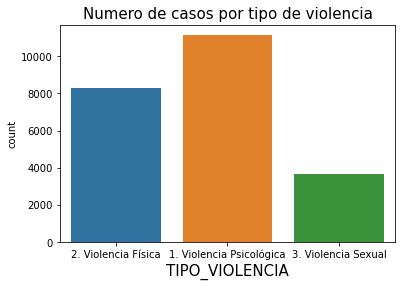

In [952]:
sns.countplot(data = dataframe, x = 'TIPO_VIOLENCIA')
plt.xlabel('TIPO_VIOLENCIA', fontsize = 15)
plt.title('Numero de casos por tipo de violencia', fontsize = 15)
plt.show()